<a href="https://colab.research.google.com/github/nicole-sb/atari-HEAD/blob/main/pacman_attention_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
import torch
import numpy as np
from PIL import Image
import pandas as pd
from tqdm import tqdm

In [ ]:
parent_path = "/content/drive/MyDrive/ErdosBootcampProject"

In [ ]:
train_path = "{}/raw_data/highscore".format(parent_path)

In [ ]:
tars = glob.glob("{}/*.tar.bz2".format(train_path))
tars

['/content/drive/MyDrive/ErdosBootcampProject/raw_data/highscore/118_RZ_4303947_Sep-01-17-15-39.tar.bz2',
 '/content/drive/MyDrive/ErdosBootcampProject/raw_data/highscore/593_RZ_5037271_Aug-05-15-35-12.tar.bz2']

In [ ]:
!tar xjf {tars[0]}

In [ ]:
meta_data = pd.read_csv("{}/raw_data/combined.csv".format(parent_path))
data_len = int(meta_data.loc[1764212, 'frame_id'].split('_')[-1])
tar_name = tars[0].split('/')[-1].split('.tar')[0]
prefix = "RZ_4303947_"
def load_img(index):
  return Image.open("{}/{}{}.png".format(tar_name, prefix, index+1)).convert('RGB')

#Read entire dataset into memory
X_train = [np.array(load_img(i)) for i in range(data_len)]

In [ ]:
meta_data.loc[1764212, 'frame_id'].split('_')[-1]

'RZ_5037271_17381'

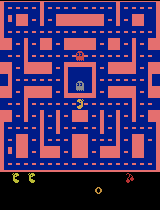

In [ ]:
load_img(0)

In [ ]:
meta_data.query("`frame_id` == '{}'".format(prefix+"1"))

In [ ]:
##Make a dictionary to look up gaze positions by frame_id
meta_data.query("`frame_id` == '{}{}'".format(prefix, 1))

In [ ]:
def get_gaze_list(data, frame_index, threshold=10):
  sub_df = data.query("`frame_id` == '{}{}'".format(prefix, frame_index+1))
  sub_df = sub_df.groupby(np.arange(len(sub_df))//threshold).mean()
  gaze_tups = list(zip(sub_df.gaze_position_x, sub_df.gaze_position_y))
  rep_img = [frame_index for _ in range(len(gaze_tups))]
  return zip(rep_img, gaze_tups)

#get_gaze_list(meta_data, 0)
gaze_dict = { str(frame_index) : get_gaze_list(frame_index) for frame_index in range(data_len)}

In [ ]:
class AtariDataset(torch.data.Dataset):
    def __init__(self, captionsDir, imagesDir, pickleDir, captionToImageRatio=10, imageTransform=None, split='train', maxCaptionLength = 18):
        # load pickle serializations for data grabbing
        # THIS ASSUMES THAT PICKLE DATA IS AVAILABLE
        # image data includes a list of captions for each image
        self.captionsDir = captionsDir
        self.imagesDir = imagesDir
        if split == 'train':
            # cub train data mappings
            with open(os.path.join(pickleDir,'trainImagesCUB.pickle'),'rb') as obj:
                self.imageData = pickle.load(obj,encoding='bytes')
            with open(os.path.join(pickleDir,'CUBWordToIndex.pickle'),'rb') as obj:
                self.wordToIndex = pickle.load(obj, encoding='bytes')
            with open(os.path.join(pickleDir,'CUBIndexToWord.pickle'),'rb') as obj:
                self.indexToWord = pickle.load(obj,encoding='bytes')
            with open(os.path.join(pickleDir,'CUBTrainID.pickle'),'rb') as obj:
                self.IDList = pickle.load(obj,encoding='bytes')
        elif split == 'test' and os.path.basename(os.path.dirname(imagesDir))=='CUB_200_2011':
            # cub test data mappings
            with open(os.path.join(pickleDir, 'testImagesCUB.pickle'), 'rb') as obj:
                self.imageData = pickle.load(obj, encoding='bytes')
            with open(os.path.join(pickleDir, 'CUBWordToIndex.pickle'), 'rb') as obj:
                self.wordToIndex = pickle.load(obj, encoding='bytes')
            with open(os.path.join(pickleDir, 'CUBIndexToWord.pickle'), 'rb') as obj:
                self.indexToWord = pickle.load(obj, encoding='bytes')
            with open(os.path.join(pickleDir, 'CUBTestID.pickle'), 'rb') as obj:
                self.IDList = pickle.load(obj, encoding='bytes')

    def __len__(self):
        # we will return the number of images
        return len(self.imageData)

    def __getitem__(self,index):
        img = Image.open(os.path.normpath(os.path.join(self.imagesDir,"{}{}".format(prefix, index+1)).replace('\\','/'))).convert('RGB')
        #print(imgData[0])

        # perform any transforms needed on the image
        if imgData[2] is not None:
            bbox=imgData[2]
            # then bounding boxes, we have cub data
            width,height = img.size
            # bbox[0] is left x pixel, bbox[1] is the top y pixel of the bounding box
            # bbox[2] is the width of the bounding box containing the bird
            # bbox[3] is the height of the bounding box containing the bird
            # we do not want to crop the image right to the bird
            # instead, the paper stackgan mentions they crop bounding boxes of the birds
            # # so that they have greater than 0.75 object-image size ratios
            # # therefore, we pick the max width/height of the box and crop 0.25 more of what the dataset preparers
            # # say to crop
            r = int(np.maximum(bbox[2], bbox[3]) * 0.75)
            center_x = int(bbox[0] + (bbox[2]/2))
            center_y = int(bbox[1]+(bbox[3])/2)
            # new bottom coordinate of the cropped image
            y1 = np.maximum(0, center_y - r)
            # new top coordinate of the cropped image
            y2 = np.minimum(height, center_y + r)
            # new left most x coordinate of the cropped image
            x1 = np.maximum(0, center_x - r)
            # new right most x coordinate of the cropped image
            x2 = np.minimum(width, center_x + r)
            img = img.crop([x1, y1, x2, y2])
            # showing image here just for testing
            #img.show()

        if self.imageTransform is not None:
            img = self.imageTransform(img)

        # normalizing channels of the image
        img = self.normalize(img)


        # need to do just a tiny bit of work to the caption before returning
        numWords = len(randCaption)
        # just padding with zeroes
        padded = np.zeros((self.maxCaptionLength,1))

        # if the text is longer than 18, we need to rearrange the sentence so it makes sense with 18 tokens
        # so, all 18 tokens should be in order

        if numWords <= self.maxCaptionLength:
            # no issues here, our caption is less than the max
            padded[:numWords,0] = randCaption
        else:
            # grabbing indices of words as a list
            indices = np.arange(numWords)
            # shuffling the indices
            np.random.shuffle(indices)
            # limiting the indices
            indices = indices[:self.maxCaptionLength]
            # sorting the indices so the sentence order is preserved
            indices = np.sort(indices)
            # now just setting the pad based on the index
            for index,wordIndex in enumerate(indices):
                padded[index,0] = randCaption[wordIndex]

        return img, padded, min(numWords,self.maxCaptionLength), classID

In [ ]:
#Load combined.csv file
df = pd.read_csv('/content/drive/MyDrive/erdos/ErdosBootcampProject/raw_data/combined.csv')

gaze_x = df.gaze_position_x
gaze_y = df.gaze_position_x
frame_id = df.frame_id

,frame_id,score,duration,unclipped_reward,action_int,gaze_position_x,gaze_position_y,action_str,trial_id
0,RZ_4303947_1,NaN,2817,0,4,79.81,118.15,PLAYER_A_LEFT,118_RZ_4303947
1,RZ_4303947_1,NaN,2817,0,4,79.69,119.38,PLAYER_A_LEFT,118_RZ_4303947
2,RZ_4303947_1,NaN,2817,0,4,79.67,120.15,PLAYER_A_LEFT,118_RZ_4303947
3,RZ_4303947_1,NaN,2817,0,4,79.64,121.30,PLAYER_A_LEFT,118_RZ_4303947
4,RZ_4303947_1,NaN,2817,0,4,79.60,121.65,PLAYER_A_LEFT,118_RZ_4303947


In [ ]:
h,w = 210,160
hidden_size = 256
batch_size = 16

In [ ]:
class Mask(torch.nn.Module):
  def  __init__(self):
      super().__init__()
      self.MLP = torch.nn.Sequential(
          torch.nn.Linear(in_features=1000, out_features =  64),
          torch.nn.ReLU(),
          torch.nn.Linear(in_features=65, out_features=h*w*1) #
      )
      self.sigmoid = torch.nn.Sigmoid()

      def forward(self, random_vector, gaze_bias):
      """
      Given a random vector of length 1000, this makes a learned weighted mask
      Args:
        - random_vector (Tensor): Our input random vector with shape (1000,)
        - gaze_bias (Tensor): Our one-hot-encoded tensor with shape (1, h, w)
      Returns:
        - out (Tensor): Our learned weighted mask, which will be applied to our input image later
      """
        #start we have x with shape (1000,)
        #apply our fully connected layer
        out = self.MLP(random_vector) #This should now have a shape of (h*w*1)
        out = out.view() #unflatten
        #apply gaze_bias to learned mask
        out = out + gaze_bias
        #apply sigmoid now to make values go between 0 and 1
        return self.sigmoid(out)

class CNN(torch.nn.Module):
  def  __init__(self):
      super().__init__()
      
      self.learned_mask = Mask()

      self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=100, kernel_size=3, stride=1)
      self.relu = torch.nn.ReLU()
      self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)

      self.flatten = torch.nn.Flatten()
      self.MLP = torch.nn.Sequential(
          torch.nn.Linear(in_features = 100*h*w, out_features=16),
          torch.nn.ReLU(),
          torch.nn.Linear(in_features=16, out_features=9)
      )
      self.final_activation = torch.nn.Softmax()
 
  def forward(self, x, random_vector, mask):
     """
    This applies our input image with the mask and then runs it through the rest of the CNN
    Args:
      - x (Tensor): Our input image with shape (3, h, w)
      - random_vector (Tensor): Random vector used to make mask with shape (1000)
      - gaze_bias (Tensor): Our one-hot-encoded tensor with shape (1, h, w)
    Returns:
      - prediction: Which action?
    """
    learned_weight_mask = self.learned.mask(random_vector)

    
    #Apply the mask to the image to get initial input to CNN parts
    out = torch.mul(x, learned_weight_mask) #shape (3,h,w)

    out = self.conv1(out) #shape (100,h,w)
    out = self.relu1(out)
    out = self.maxpool1(out) #shape (100,h,w)

    #apply the fully connected layers
    out = self.flatten(out)

    out = self.final_activation(self.MLP(out)) #this will get you probability vector with probs for each class
    
    #Output the class associated with the highest probability
    return torch.argmax(out)

In [ ]:
num_epochs = len()  #Number of epochs correspond to the number of images 17814
training_data = None #TODO: load training data (images, gaze_coords)
cnn_model = CNN()
opt_cnn = torch.optim.SGD(cnn_model.parameters(), lr=1e-2, momentum=0.9)
loss_func = torch.nn.CrossEntropyLoss()

#This is training
for epoch in range(num_epochs):
  for image, gaze_coords, y in training_data:
    #Every step

    #Grab the gaze coordinates to do one hot encoding
    gaze_x, gaze_y = gaze_coords[0], gaze_coords[1]

    #Make one hot encoded gaze_bias
    gaze_bias = torch.zeros((1, h, w), requires_grad=False)
    gaze_bias[:, gaze_y, gaze_x] = 1

    #Make random vector that will be used to make mask
    random_vector = torch.rand(1000, requires_grad=True)

    #Zero gradients before calculating gradients of loss with respect to the image
    opt_cnn.zero_grad()

    #Pass image into cnn_model
    y_hat = cnn_model(image, random_vector, gaze_bias)
    
    #Calculate loss 
    loss = loss_func(y_hat, y)

    #Calcualte gradients with backprob
    loss.backward()

    #Step optimizer to update weights with new grads
    opt_cnn.step()


SyntaxError: ignored